## Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

# Import the sklearn modules scaler, pca and k-means.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# We import pickle in order to be able to load our pickled objects.
import pickle
# We import the Logistic Regression module from sk learn for the purchase probability model.
from sklearn.linear_model import LogisticRegression 
#We import the necessary libraries for visualization. We set seaborn do be our default.
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()
# We import the Linear Regression module from sk learn for the quantity model.
from sklearn.linear_model import LinearRegression

## Data Preparation

### Data Dictionary
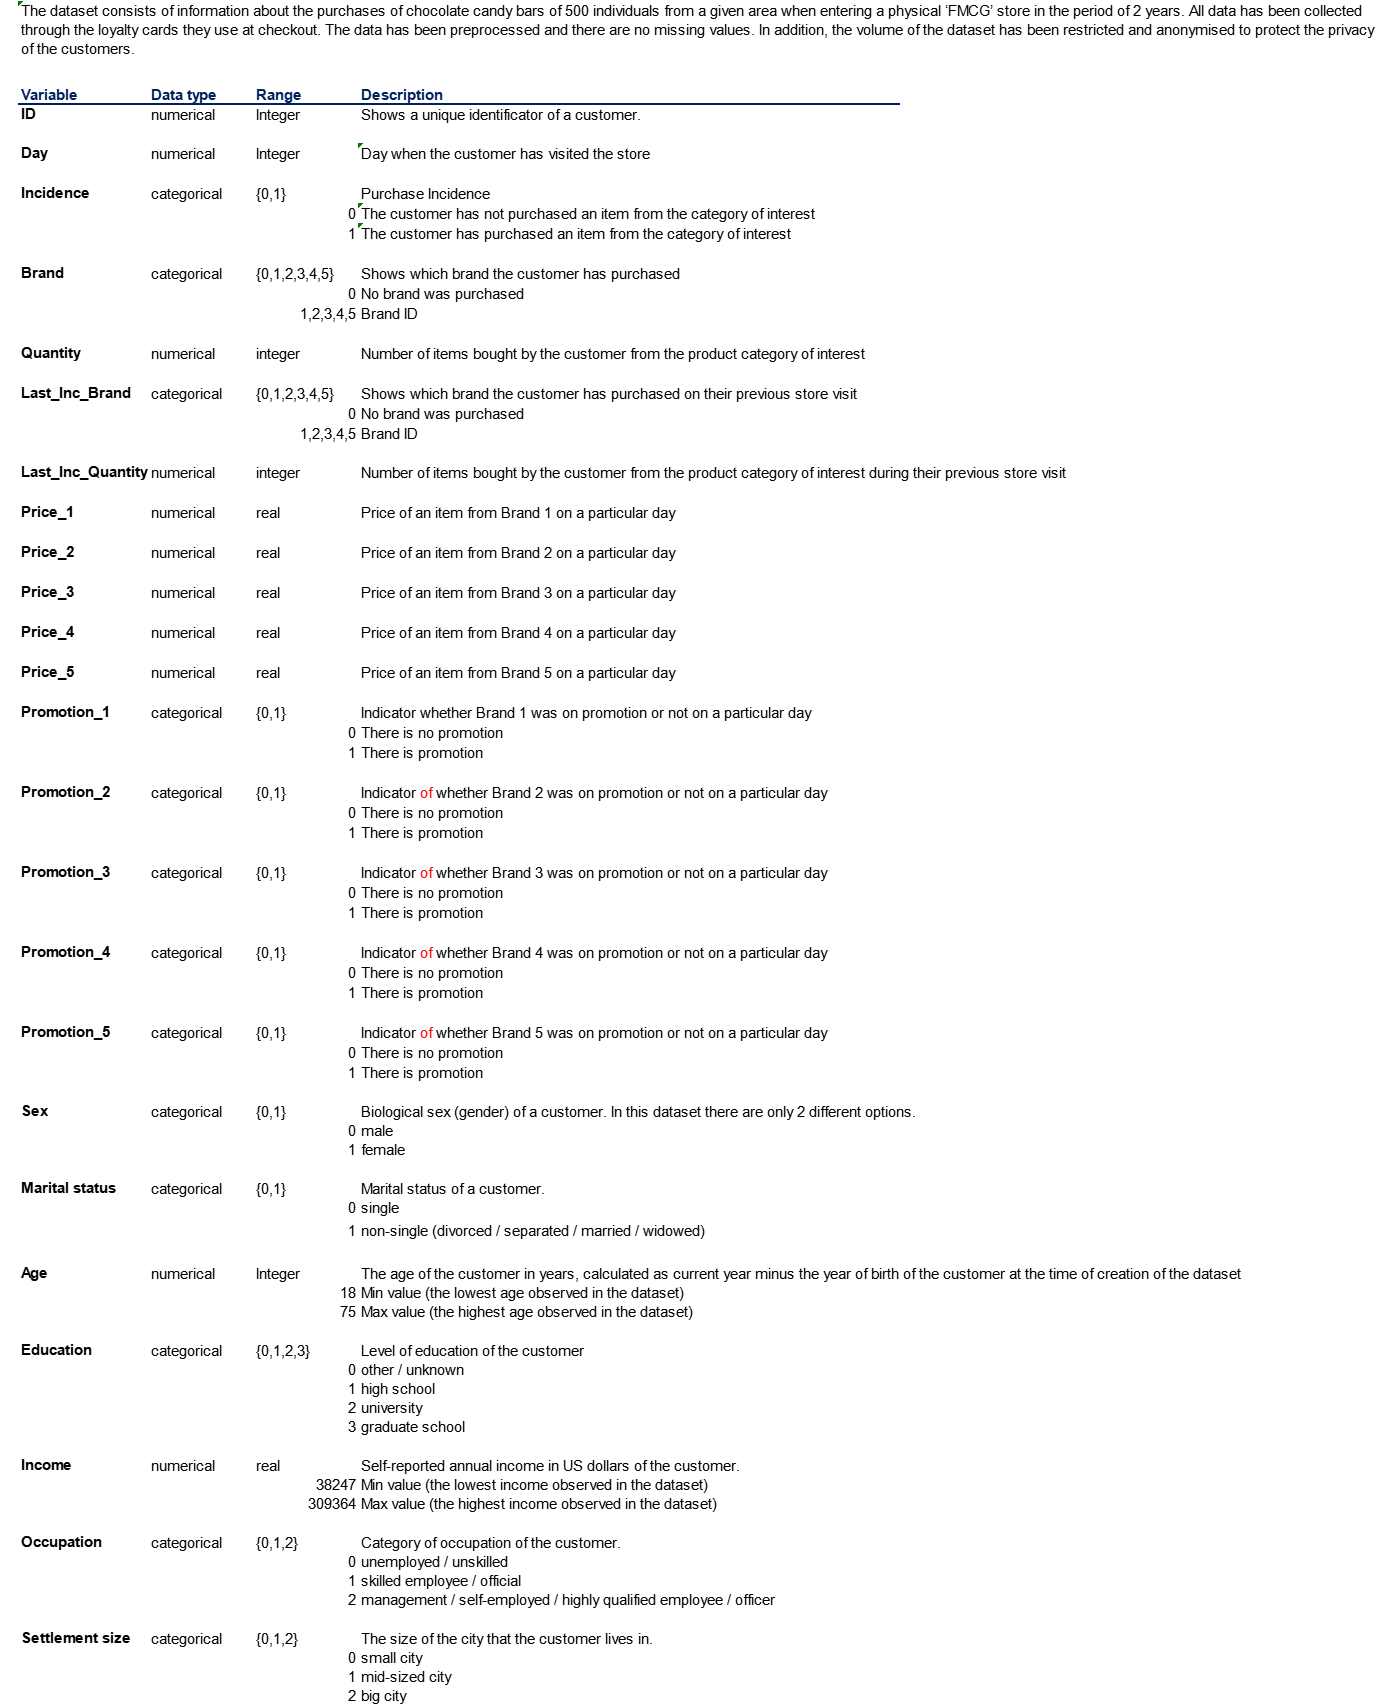

In [ ]:
#load data
# df_purchase = pd.read_csv('purchase data.csv')
df_purchase = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UD_Cust_Analytics/purchase data.csv')

# Import Scaler
#scaler = pickle.load(open('scaler.pickle', 'rb'))
scaler = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/UD_Cust_Analytics/scaler.pickle', 'rb'))

# Import PCA
#pca = pickle.load(open('pca.pickle', 'rb'))
pca = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/UD_Cust_Analytics/pca.pickle', 'rb'))

# Import K-Means
#kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))
kmeans_pca = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/UD_Cust_Analytics/kmeans_pca.pickle', 'rb'))
# Standardization
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)
# Apply PCA
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)
# Segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

# Create a copy of the data frame
df_purchase_predictors = df_purchase.copy()
# Add segment labels
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

df_pa = df_purchase_predictors
df_pa.head()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator KMeans from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0


In [ ]:
df_pa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58693 entries, 0 to 58692
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 58693 non-null  int64  
 1   Day                58693 non-null  int64  
 2   Incidence          58693 non-null  int64  
 3   Brand              58693 non-null  int64  
 4   Quantity           58693 non-null  int64  
 5   Last_Inc_Brand     58693 non-null  int64  
 6   Last_Inc_Quantity  58693 non-null  int64  
 7   Price_1            58693 non-null  float64
 8   Price_2            58693 non-null  float64
 9   Price_3            58693 non-null  float64
 10  Price_4            58693 non-null  float64
 11  Price_5            58693 non-null  float64
 12  Promotion_1        58693 non-null  int64  
 13  Promotion_2        58693 non-null  int64  
 14  Promotion_3        58693 non-null  int64  
 15  Promotion_4        58693 non-null  int64  
 16  Promotion_5        586

In [ ]:
df_pa.Segment.value_counts()

2    21495
1    13580
0    12123
3    11495
Name: Segment, dtype: int64

## Purchase Probability Model for Given price

First thing we need to model purchase probability as we have purchase incidence variable.
* In order to do that we will have to select the Incidence in Y variable and Price as X (independent variable). as we are working for the category we need to take the average across the brands to get average category price.
* Next we will use the logistic regression to get probabilities, we will use `'sag'` as it will converge faster.
* Next we need to get the coef_ from the model 

*### to understand the elasticity. the sign represents positive or negative relations and the value represent the degree of influence.

In [ ]:
# Create Y dependent variable as we want to model purchase incidence

Y = df_pa['Incidence']

In [ ]:
# Our dependant variable is based on the average price of chocolate candy bars. 
# Therefore, X is a data frame, containing the mean price across the five prices(consider category price).
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5

In [ ]:
# We create a Logistic Regression model using sk learn. 
# Then we fit the model with our X or price and our Y or incidence.
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(solver='sag')

In [ ]:
# The coefficients for price. It is negative, signaling that with an increase in price, 
# the purchase probability decreases.
model_purchase.coef_

array([[-2.34788768]])

## Price Elasticity of Purchase Probability

Now that we have modeled the purchase probability. let us calculate the price elasticity. Since we used incidence of purchase to model our purchase probability what we can calculate is `price elasticity of purchase probability` it is no indication of quantity purchased.

In order to calculate the `price elasticity of purchase probability` we use the following formula. 
* (1 - Y) * Beta(price) * price
    * where Y = purchase probability (logit function)
            Beta(price) = beta coeff of purchase probability model
            price = price point

before applying the formula we need to create a range of price point which represent the range of price points for the category.

Once we calculate the price points and their respective elasticity we can plot the same to see the `price elasticity for purchase probability curve`.

The `price elasticity of purchase probability` curve shows the change of purchase probability for each price point.

In [ ]:
# Here we see the prices for the five different brands, 
    # which is an important factor in determining purchase probability. 
# It informs the price range, for which we will be exploring purchase probability.
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


**We introduce the price range for which we'll examine the purchase probability.**

We choose a price range between 0.5 and 3.49, which somewhat expands the actual observed price range, which is from 1.1 to 2.8.

In [ ]:
# Create a price range to test purchase probability for every price point
price_range = np.arange(0.5, 3.5, 0.01)
price_range

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
       0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04,
       1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37,
       1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48,
       1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59,
       1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 ,
       1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81,
       1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92,
       1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.

In [ ]:
# Let us create a dataframe for the price range
df_price_range = pd.DataFrame(price_range)

**Let's predict the purchase probability for all the price points using our model we built**

The result will be a 2X300 array. The first column shows the probability for `not purchasing the product` and the second column will show probability for `purchasing the product`for each price point in the price range we just created.

In [ ]:
# We predict the purchase probability for our newly defined price range. 

Y_pr = model_purchase.predict_proba(df_price_range) # Store the predicted probabilities in a variable
purchase_pr = Y_pr[:][:, 1] # Select the probabilities for purchase and store in a variable
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr) # Calculate elasticity using the formula

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
# Create price elasticities master data frame with all the elsticities for each price point

df_price_elasticities = pd.DataFrame(price_range) # create dataframe with price points

df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"}) # Name the column
df_price_elasticities['Mean_PE'] = pe # add a new column for price elasticity and add values
df_price_elasticities # display the DF

,Price_Point,Mean_PE
0,0.50,-0.096383
1,0.51,-0.100450
2,0.52,-0.104645
3,0.53,-0.108969
4,0.54,-0.113427
...,...,...
295,3.45,-8.012279
296,3.46,-8.037527
297,3.47,-8.062742
298,3.48,-8.087922


In [ ]:
pd.options.display.max_rows = None # to see all the rows of the dataframe
df_price_elasticities # Show DF

,Price_Point,Mean_PE
0,0.50,-0.096383
1,0.51,-0.100450
2,0.52,-0.104645
3,0.53,-0.108969
4,0.54,-0.113427
5,0.55,-0.118021
6,0.56,-0.122755
7,0.57,-0.127632
8,0.58,-0.132656
9,0.59,-0.137830


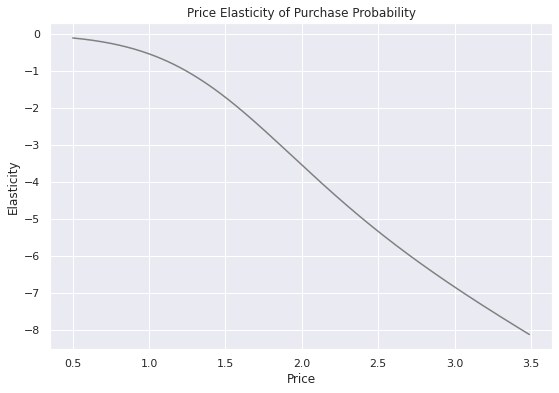

In [ ]:
# We display the price elasticity of purchase probability of the average customer.
# We observe that the price elasticities are all negative. Furthermore we can spot where the customer becomes inelastic.
# But to find the precise spot we can consult the price elasticities data frame.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

## Purchase Probability by Segments

Let's now check elasticity for each segment and compare it to the category price elasticity of purchase probability curve.

### $\color{green}{\text{Segment 1 - Career-Focused}}$

In [ ]:
# filter the data to contain only customers from segment 1, the career-focused.
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]

In [ ]:
# Again as we want to predict the purchase probability, so our Y variable is the incidence column.
# Only here we select only the customers from the first segment.
Y = df_pa_segment_1['Incidence']

In [ ]:
X = pd.DataFrame()

In [ ]:
# calculate the average price for purchases in segment 1. 
# Our dependant variable contains the mean price of the brands, which represents the category price.
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

In [ ]:
# Fit logistic regression model
model_incidence_segment_1 = LogisticRegression(solver = 'sag')
model_incidence_segment_1.fit(X, Y)

LogisticRegression(solver='sag')

In [ ]:
# Check the model coef_
model_incidence_segment_1.coef_

array([[-1.71001722]])

We observe that the price coefficient for the career focused is -1.7, whereas for the average customer it was -2.35. This is an indicator, that this segment is less price sensitive compared to the average customer.

In [ ]:
# Calculate Price Elasticity of the career-focused segment.
Y_segment_1 = model_incidence_segment_1.predict_proba(df_price_range)
purchase_pr_segment_1 = Y_segment_1[:][:, 1]
pe_segment_1 = model_incidence_segment_1.coef_[:, 0] * price_range * (1 - purchase_pr_segment_1)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


### Results

In [ ]:
df_price_elasticities['PE_Segment_1'] = pe_segment_1
df_price_elasticities.head()

,Price_Point,Mean_PE,PE_Segment_1
0,0.50,-0.096383,-0.118736
1,0.51,-0.100450,-0.122906
2,0.52,-0.104645,-0.127168
3,0.53,-0.108969,-0.131524
4,0.54,-0.113427,-0.135977


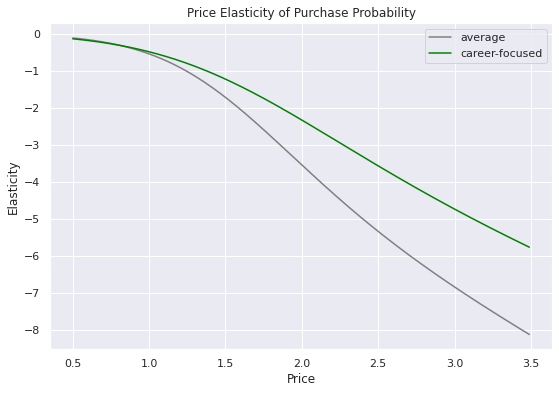

In [ ]:
# plot the elasticities of the average customer and the career-focused segment side by side. 

plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey', label = 'average')
plt.plot(price_range, pe_segment_1, color = 'green', label = 'career-focused')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.legend()
plt.title('Price Elasticity of Purchase Probability')
plt.show()

One can clearly see the price elasticity curve for career focused is sitting right on top of the average curve, also one can note that the slope for the career focused is less. Which clearly indicate that the segment is less price sensitive.

### $\color{red}{\text{Segment 2 - Fewer-Opportunities}}$

Repeat the above steps for `Fewer-Opportunities` segment

In [ ]:
# Select only customers from segment 2, the fewer-opportunities.
df_pa_segment_2 = df_pa[df_pa['Segment'] == 2]

In [ ]:
# Logistic regression model
Y = df_pa_segment_2['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5

model_incidence_segment2 = LogisticRegression(solver = 'sag')
model_incidence_segment2.fit(X, Y)

# Calculate price elasticities
model_incidence_segment2.coef_
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[:][: , 1]
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range * ( 1- purchase_pr_segment2)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


### Results

In [ ]:
df_price_elasticities['PE_Segment_2'] = pe_segment2
df_price_elasticities.head()

,Price_Point,Mean_PE,PE_Segment_1,PE_Segment_2
0,0.50,-0.096383,-0.118736,-0.030918
1,0.51,-0.100450,-0.122906,-0.032684
2,0.52,-0.104645,-0.127168,-0.034538
3,0.53,-0.108969,-0.131524,-0.036482
4,0.54,-0.113427,-0.135977,-0.038520


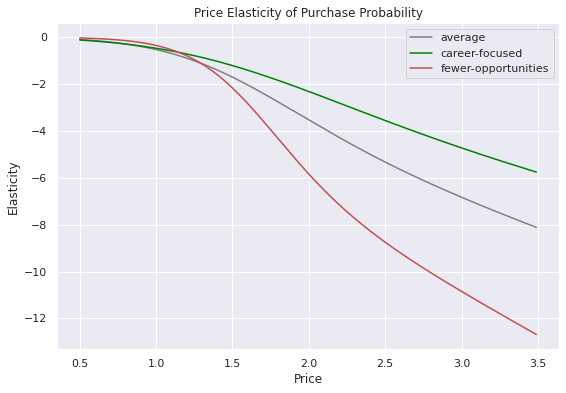

In [ ]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey', label = 'average')
plt.plot(price_range, pe_segment_1, color = 'green', label = 'career-focused')
plt.plot(price_range, pe_segment2, color = 'r', label = 'fewer-opportunities')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.legend()
plt.title('Price Elasticity of Purchase Probability')
plt.show()

One can easily note from the plot above that the `fewer opportunities` segment is not sensitive at price points less than 1.2 but above that the segment is highly sensitive.

### $\color{blue}{\text{Segment 0 - Standard}}$

In [ ]:
# Select only customers from segment 0, the standard segment.
df_pa_segment_0 = df_pa[df_pa['Segment'] == 0]
# Prepare dependant and independant variables.
Y = df_pa_segment_0['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5
# Logistic regression model
model_incidence_segment0 = LogisticRegression(solver = 'sag')
model_incidence_segment0.fit(X, Y)

model_incidence_segment0.coef_
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[:][: , 1]
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range *( 1- purchase_pr_segment0)
df_price_elasticities.insert(2, column = 'PE_Segment_0', value = pe_segment0)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


### $\color{orange}{\text{Segment 3 - Well-Off}}$

In [ ]:
# Select only customers from segment 3 
df_pa_segment_3 = df_pa[df_pa['Segment'] == 3]
# Prepare dependant and independant variables.
Y = df_pa_segment_3['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5
# Logistic regression model
model_incidence_segment3 = LogisticRegression(solver = 'sag')
model_incidence_segment3.fit(X, Y)

model_incidence_segment3.coef_
Y_segment_3 = model_incidence_segment3.predict_proba(df_price_range)
purchase_pr_segment3 = Y_segment_3[:][: , 1]
pe_segment3 = model_incidence_segment3.coef_[:,0] * price_range *( 1- purchase_pr_segment3)
df_price_elasticities['PE_Segment_3'] = pe_segment3
df_price_elasticities.head()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3
0,0.50,-0.096383,-0.211059,-0.118736,-0.030918,-0.168348
1,0.51,-0.100450,-0.217626,-0.122906,-0.032684,-0.173284
2,0.52,-0.104645,-0.224300,-0.127168,-0.034538,-0.178291
3,0.53,-0.108969,-0.231082,-0.131524,-0.036482,-0.183370
4,0.54,-0.113427,-0.237974,-0.135977,-0.038520,-0.188520


### ${\textbf{Results}}$

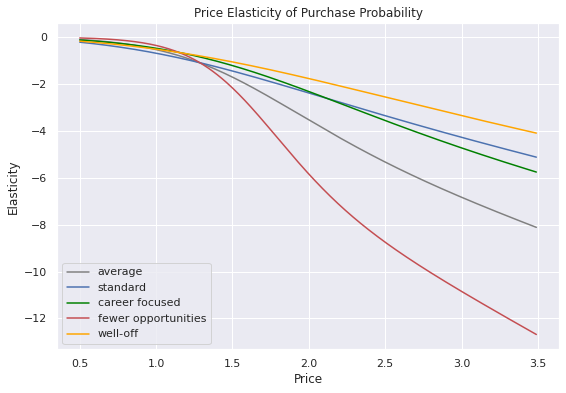

In [ ]:
# display all elasticities of purchase probability on the same plot. 
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey', label = 'average')
plt.plot(price_range, pe_segment0, color = 'b', label = 'standard')
plt.plot(price_range, pe_segment_1, color = 'green', label = 'career focused')
plt.plot(price_range, pe_segment2, color = 'r', label = 'fewer opportunities')
plt.plot(price_range, pe_segment3, color = 'orange', label = 'well-off')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.legend()
plt.title('Price Elasticity of Purchase Probability')
plt.show()

We observe that the well-off segment are the least elastic followed by career focused segment, their purchase probability elasticity is not much affected by price.

The price elasticities for the Standard segment seem to differ across price range. They are the more sensitive to change in price at lower prices than any other group but they show lesser sensitivity at the higher price bands compared to other segments. This may be due to the fact that the standard segment is least homogeneous, which we discovered during our descriptive analysis, brand choice. 
It may be that the customers in this segment have different shopping habits, which is why their  customers start with being more elastic than average but then shift to being more inelastic than the average customer and indeed the Career-focused segment.

## Purchase Probability with Promotion Feature

### Data Preparation

We will still use purchase incidence to calculate purchase probability. however as we are factoring for promotion we will use promotion as an additional feature along side price to model purchase probability.

We will work on average purchase probability for average price and average promotion.

In [ ]:
Y = df_pa['Incidence']

In [ ]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5']) / 5

In [ ]:
# We include a second promotion feature. 
# We'd like to examine the effects of promotions on purchase probability.
# We calculate the average promotion rate across the five brands. We add the mean price for the brands.
X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'] ) / 5
X.head()

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0


### Model Estimation

In [ ]:
model_incidence_promotion = LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X, Y)
model_incidence_promotion.coef_

array([[-1.49389579,  0.56147553]])

The coefficient for promotion is positive. Therefore, there is a positive relationship between promotion and purchase probability.

### Price Elasticity with Promotion

Price elasticity is calculated similar to what we have done previously, using the logistic regression model we trained with price and promo features. 

We first will create a price range. Next we need to provide the promotion coefficient - we shall assume that at any given price point there is a promotion being applied. 

In [ ]:
# create a data frame on which our model will predict. We need to include price and promotion features.
# First, we'll include the price range as the price feature. Next, we'll include the promotion feature.
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion.rename(columns = {0: "Price_Range"})

In [ ]:
# We'll calculate price elasticities of purchase probability
# under the assumption that there is a promotion across at each price points.
df_price_elasticity_promotion['Promotion'] = 1

In [ ]:
# Predict Purchase Probability with Promotion using the Model
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Price_Range
- Promotion
Feature names seen at fit time, yet now missing:
- Mean_Price
- Mean_Promotion

  warnings.warn(message, FutureWarning)


In [ ]:
# Calculate purchase probability using the formula
promo = Y_promotion[:, 1] # store the probability of purchase in a variable
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo)

In [ ]:
# Update master data to include elasticities of purchase probability with promotion feature
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1
0,0.50,-0.096383,-0.211059,-0.118736,-0.030918,-0.168348,-0.125727
1,0.51,-0.100450,-0.217626,-0.122906,-0.032684,-0.173284,-0.129842
2,0.52,-0.104645,-0.224300,-0.127168,-0.034538,-0.178291,-0.134037
3,0.53,-0.108969,-0.231082,-0.131524,-0.036482,-0.183370,-0.138312
4,0.54,-0.113427,-0.237974,-0.135977,-0.038520,-0.188520,-0.142667
5,0.55,-0.118021,-0.244976,-0.140527,-0.040658,-0.193742,-0.147105
6,0.56,-0.122755,-0.252088,-0.145175,-0.042899,-0.199036,-0.151625
7,0.57,-0.127632,-0.259312,-0.149924,-0.045248,-0.204404,-0.156229
8,0.58,-0.132656,-0.266648,-0.154775,-0.047709,-0.209845,-0.160919
9,0.59,-0.137830,-0.274097,-0.159729,-0.050288,-0.215360,-0.165694


### Price Elasticity without Promotion

First we got the elasticity while the promotion is applied, let us now calculate the price elasticity for promotion not being applied.

In [ ]:
# Prepare the data for prediction
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = df_price_elasticity_promotion_no.rename(columns = {0: "Price_Range"})

In [ ]:
# Promotion feature -No Promotion.
# We assume there aren't any promotional activities on any of the price points.
# We examine the elasticity of purchase probability when there isn't promotion.
df_price_elasticity_promotion_no['Promotion'] = 0

In [ ]:
# Predict Purchase Probability without Promotion using the Model
Y_no_promo = model_incidence_promotion.predict_proba(df_price_elasticity_promotion_no)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Price_Range
- Promotion
Feature names seen at fit time, yet now missing:
- Mean_Price
- Mean_Promotion

  warnings.warn(message, FutureWarning)


In [ ]:
# Calculate elasticity using the formula
no_promo = Y_no_promo[: , 1]
price_elasticity_no_promo = model_incidence_promotion.coef_[:, 0] * price_range *(1- no_promo)

In [ ]:
# Update master data frame to include purchase probability elasticities without promotion.
# We can now see the values with and without promotion and 
# compare them for each price point in our price range.
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo

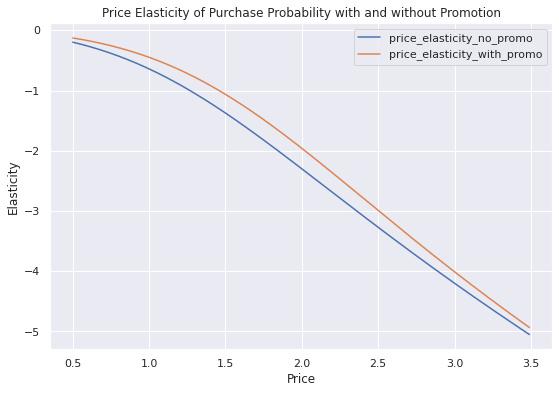

In [ ]:
# Plot purchase elasticities with and without promotion side by side for comprarisson.
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_no_promo, label = 'price_elasticity_no_promo')
plt.plot(price_range, price_elasticity_promo, label = 'price_elasticity_with_promo')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.legend()
plt.title('Price Elasticity of Purchase Probability with and without Promotion')
plt.show()

Here we observe that the purchase probability elasticity of the customer is less elastic when there is promotion.

This is an important insight for marketers, as according to our model people are more likely to buy a product if there is some promotional activity rather than purchase a product with the same price, when it isn't on promotion. 

## ${\textbf{Brand Choice}}$

### Data Preparation

Now let us model brand choice of the customer. The objective here is to understand at a given price point (own price and competitor price) what is brand choice of the customer. How the customer preference changes to the change in brand's own price and also change in competitor price change. Note the function here is purchase probability of brand (brand choice) is dependent on price of the brand and price of all the substitutes and while one price changes all other prices are constant.

So, we will slice the data for where the purchase has happened, i.e. where the incidence is 1.
our independent features shall be price of all the brands and our dependent variable will be brand that is purchased.

Once data is prepared we shall model using logistic regression.

In [ ]:
# Here we are interested in determining the brand choice of the customer. 
# Hence, we filter our data, to include only purchase occasion, when a purchase has occured. 
brand_choice = df_pa[df_pa['Incidence'] == 1]

In [ ]:
# We cap the maximum displayed rows in a table, to make computation more efficient and easier readability.
pd.options.display.max_rows = 100
brand_choice

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,2.09,2.67,0,0,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,2.12,2.62,1,0,0,0,1,0,0,47,1,110866,1,0,2,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,1.97,2.67,0,0,0,1,0,0,0,47,1,110866,1,0,2,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,2.16,2.68,1,1,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,1.89,2.37,1,0,0,1,1,0,0,47,1,110866,1,0,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58621,200000500,296,1,2,6,0,0,1.48,1.89,2.01,2.18,2.69,0,0,0,0,0,0,0,42,1,120946,1,0,2,0,0,1,0
58648,200000500,460,1,1,12,0,0,1.35,1.57,2.02,2.21,2.70,1,1,0,0,0,0,0,42,1,120946,1,0,2,0,0,1,0
58674,200000500,641,1,2,7,0,0,1.50,1.85,2.06,2.24,2.79,1,1,0,0,0,0,0,42,1,120946,1,0,2,0,0,1,0
58687,200000500,697,1,2,6,0,0,1.42,1.51,1.97,2.24,2.78,0,0,0,0,0,0,0,42,1,120946,1,0,2,0,0,1,0


In [ ]:
# Our model will predict the brand.
Y = brand_choice['Brand']

In [ ]:
# Here we decide which features to include for prediction.
# brand_choice.columns.values

In [ ]:
# We predict based on the prices for the five brands.
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = brand_choice[features]

In [ ]:
# Brand Choice Model fit.
model_brand_choice = LogisticRegression(solver = 'sag', multi_class = 'multinomial')
model_brand_choice.fit(X, Y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [ ]:
# Here are the coeffictients for the model. We have five brands and five features for the price. 
# Therefore, this output is somewhat difficult to read.
model_brand_choice.coef_

array([[-3.91597181,  0.65845249,  2.41766463,  0.70407303, -0.20212583],
       [ 1.27460657, -1.87985807, -0.21266561, -0.20634596,  0.58786352],
       [ 1.62422195,  0.56212556,  0.5010052 ,  1.0395351 ,  0.4528259 ],
       [ 0.5745294 ,  0.39558463, -1.40063317, -1.24624952,  0.24934253],
       [ 0.4426139 ,  0.26369539, -1.30537104, -0.29101265, -1.08790611]])

As we have fit a mutinomial logistic model to predict five clases we will hvae 5 models built based on 5 input features. hence will have 5 X 5 metrics of coefficients. let us make a data frame with interpretable labels.

In [ ]:
# create a data frame, which contains to coefficients.
bc_coef = pd.DataFrame(model_brand_choice.coef_)

# Transpose the data frame, to keep with the conventional representation of results.
# Add labels for the columns and the index, 
# which represent the coefficients of the brands and prices, respectively. 
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
coefficients = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
bc_coef.columns = [coefficients]
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


Note that intersection of price of the brand with coef of the brand represent the brand preference with respect to change in brand's own price. example brand_1 coef with respect to price_1 is -3.92 it shows there is a negative relationship with price. However if we see the brand 3 coef is positive, which is highly unlikely. This may be because the transactions for brand 3 are very less, it is not popular among any segment. let us understand the price elasticity for brand 5 own price.

## Own Price Elasticity Brand 5

As stated above for calculating `own price elasticity of brand 5` we will assume that the price point of all other brands will be constant (average price of each brand) only the price of brand 5 will change (price range).

In [ ]:
# We want to calculate price elasticity of brand choice.
# Here we create a data frame with price columns, 
# which our model will use to predict the brand choice probabilities.
df_own_brand_5 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range
df_own_brand_5

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54
...,...,...,...,...,...
295,1.384559,1.764717,2.006694,2.159658,3.45
296,1.384559,1.764717,2.006694,2.159658,3.46
297,1.384559,1.764717,2.006694,2.159658,3.47
298,1.384559,1.764717,2.006694,2.159658,3.48


In [ ]:
# Brand Choice Model prediction.
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)

In [ ]:
# Our model returns the probabilities of choosing each of the 5 brands. 
# Since, we are interested in the probability for the fifth brand 
# we need to obtain the last column located on position 4.
pr_own_brand_5 = predict_brand_5[: ][:, 4]

In [ ]:
# We're interested in choosing brand 5. 
# Therefore, the beta coefficient we require is that of the brand 5 coefficient and price 5.
beta5 = bc_coef.iloc[4, 4]
beta5

-1.09

In [ ]:
# Calculating price elasticities for brand choice without promotion. 
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pr_own_brand_5)

In [ ]:
# Adding the price elasticities to our master data frame. 
df_price_elasticities['Brand_5'] = own_price_elasticity_brand_5
pd.options.display.max_rows = None
df_price_elasticities.head()

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5
0,0.50,-0.096383,-0.211059,-0.118736,-0.030918,-0.168348,-0.125727,-0.195628,-0.049056
1,0.51,-0.100450,-0.217626,-0.122906,-0.032684,-0.173284,-0.129842,-0.201748,-0.050617
2,0.52,-0.104645,-0.224300,-0.127168,-0.034538,-0.178291,-0.134037,-0.207971,-0.052207
3,0.53,-0.108969,-0.231082,-0.131524,-0.036482,-0.183370,-0.138312,-0.214298,-0.053827
4,0.54,-0.113427,-0.237974,-0.135977,-0.038520,-0.188520,-0.142667,-0.220728,-0.055477


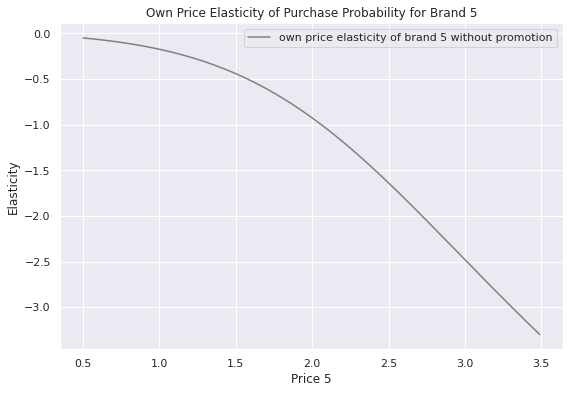

In [ ]:
# Plot elasticities of purchase probability for brand 5.
plt.figure(figsize = (9, 6))
plt.plot(price_range, own_price_elasticity_brand_5, color = 'grey', label = 'own price elasticity of brand 5 without promotion')
plt.xlabel('Price 5')
plt.ylabel('Elasticity')
plt.legend()
plt.title('Own Price Elasticity of Purchase Probability for Brand 5')
plt.show()

## Cross Price Elasticity Brand 5, Cross Brand 4

In [ ]:
# We want to examine the effect of the changes in price of a competitor brand.

df_brand5_cross_brand4 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4['Price_1'] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4['Price_2'] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4['Price_3'] = brand_choice['Price_3'].mean()
df_brand5_cross_brand4['Price_4'] = price_range
df_brand5_cross_brand4['Price_5'] = brand_choice['Price_5'].mean()

In [ ]:
df_brand5_cross_brand4.head()

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,0.50,2.654296
1,1.384559,1.764717,2.006694,0.51,2.654296
2,1.384559,1.764717,2.006694,0.52,2.654296
3,1.384559,1.764717,2.006694,0.53,2.654296
4,1.384559,1.764717,2.006694,0.54,2.654296


In [ ]:
# predict the purchase probabilities using the model_brand_choice
predict_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)

In [ ]:
# As now we're interested in what the probability of choosing the competitor brand is, 
# we need to select the purchase probability for brand 4, contained in the 4th column with index 3. 
pr_brand_4 = predict_brand5_cross_brand4[:][:, 3]

In [ ]:
beta5

-1.09

In [ ]:
# In order to calculate the cross brand price elasticity, 
# we need to use the new formula. 
#The elasticity is equal to negative the price coefficient of the own brand 
    # multiplied by the price of the cross brand,
# further multiplied by the probability for choosing the cross brand.
brand5_cross_brand4_price_elasticity = -beta5 * price_range * pr_brand_4

In [ ]:
# Update price elasticities data frame to include the 
# cross price elasticities for brand 5 with respect to brand 4.
df_price_elasticities['Brand_5_Cross_Brand_4'] = brand5_cross_brand4_price_elasticity
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4
0,0.50,-0.096383,-0.211059,-0.118736,-0.030918,-0.168348,-0.125727,-0.195628,-0.049056,0.332012
1,0.51,-0.100450,-0.217626,-0.122906,-0.032684,-0.173284,-0.129842,-0.201748,-0.050617,0.337288
2,0.52,-0.104645,-0.224300,-0.127168,-0.034538,-0.178291,-0.134037,-0.207971,-0.052207,0.342507
3,0.53,-0.108969,-0.231082,-0.131524,-0.036482,-0.183370,-0.138312,-0.214298,-0.053827,0.347669
4,0.54,-0.113427,-0.237974,-0.135977,-0.038520,-0.188520,-0.142667,-0.220728,-0.055477,0.352774
5,0.55,-0.118021,-0.244976,-0.140527,-0.040658,-0.193742,-0.147105,-0.227264,-0.057159,0.357820
6,0.56,-0.122755,-0.252088,-0.145175,-0.042899,-0.199036,-0.151625,-0.233905,-0.058871,0.362810
7,0.57,-0.127632,-0.259312,-0.149924,-0.045248,-0.204404,-0.156229,-0.240652,-0.060615,0.367741
8,0.58,-0.132656,-0.266648,-0.154775,-0.047709,-0.209845,-0.160919,-0.247507,-0.062391,0.372615
9,0.59,-0.137830,-0.274097,-0.159729,-0.050288,-0.215360,-0.165694,-0.254470,-0.064200,0.377430


Text(0.5, 1.0, 'Cross Price Elasticity of Brand 5 wrt Brand 4')

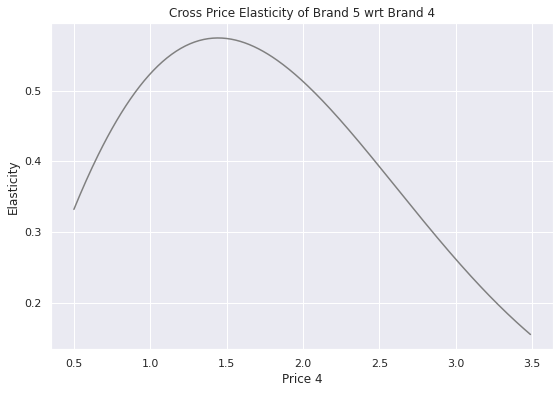

In [ ]:
# plot the cross price elasticity of brand 5 with respect to brand 4
plt.figure(figsize=(9, 6))
plt.plot(price_range,
         brand5_cross_brand4_price_elasticity,
         color='grey',
         label='cross_pr_elsti_brand5_vs_4')
plt.xlabel('Price 4')
plt.ylabel('Elasticity')
plt.title('Cross Price Elasticity of Brand 5 wrt Brand 4')

The plot above shows cross price elasticity of purchase probability for brand 5 with respect to brand 4.
We observe they are positive. As the price of the competitor brand increases, so does the probability for purchasing our own brand. Even though the elasticity starts to decrease from the 1.45 mark, it is still positive, signaling that the increase in purchase probability for the own brand happens more slowly.

## Own and Cross-Price Elasticity by Segment

### $\color{orange}{\text{Well-Off}}$

In [ ]:
# We are interested in analysing the purchase probability for choosing brand 5 by segments.
# We filter our data to contain only purchase incidences of the third segment - Well-off.
brand_choice_s3 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s3 = brand_choice_s3[brand_choice_s3['Segment'] == 3]

pd.options.display.max_rows = 60
brand_choice_s3

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
101,200000002,6,1,4,1,0,0,1.59,1.87,2.01,2.09,2.66,0,0,0,0,0,1,1,52,2,159052,2,1,3,0,0,0,1
115,200000002,100,1,4,2,0,0,1.47,1.90,1.95,2.12,2.67,0,0,0,1,0,1,1,52,2,159052,2,1,3,0,0,0,1
138,200000002,283,1,4,3,0,0,1.37,1.89,2.00,2.14,2.64,0,0,0,0,0,1,1,52,2,159052,2,1,3,0,0,0,1
141,200000002,307,1,4,1,0,0,1.34,1.89,2.01,2.03,2.68,1,0,0,1,0,1,1,52,2,159052,2,1,3,0,0,0,1
153,200000002,422,1,4,1,0,0,1.34,1.89,2.02,2.21,2.65,0,0,0,1,0,1,1,52,2,159052,2,1,3,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57346,200000489,687,1,4,1,4,1,1.50,1.87,2.06,2.24,2.78,0,0,0,0,0,1,1,44,2,193816,2,1,3,0,0,0,1
57347,200000489,693,1,4,2,4,1,1.42,1.51,2.02,2.24,2.77,0,1,0,0,0,1,1,44,2,193816,2,1,3,0,0,0,1
57348,200000489,701,1,4,3,4,1,1.42,1.85,1.99,2.24,2.76,0,0,1,0,0,1,1,44,2,193816,2,1,3,0,0,0,1
57350,200000489,715,1,4,2,0,0,1.50,1.80,2.09,2.24,2.79,0,0,0,0,0,1,1,44,2,193816,2,1,3,0,0,0,1


In [ ]:
# Brand Choice Model estimation.
Y = brand_choice_s3['Brand']
brand_choice_s3 = pd.get_dummies(brand_choice_s3, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s3[features]
model_brand_choice_s3 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s3.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s3.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.15,1.33,0.82,0.12,-0.11
Price_2,-0.96,-1.38,1.29,0.78,0.27
Price_3,2.01,-1.65,-0.49,0.03,0.11
Price_4,2.52,0.96,-0.25,-1.90,-1.33
Price_5,-0.99,-0.30,1.17,0.56,-0.44


### $\color{orange}{\text{Own-Brand Price Elasticity}}$

In [ ]:
# Calculating own-brand price elasticity for brand 5 and the Well-off segment.
df_own_brand_5_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_own_brand_5_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_own_brand_5_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_own_brand_5_s3['Price_4'] = brand_choice_s3['Price_4'].mean()
df_own_brand_5_s3['Price_5'] = price_range

predict_own_brand_5_s3 = model_brand_choice_s3.predict_proba(df_own_brand_5_s3)
pr_own_brand_5_s3 = predict_own_brand_5_s3[: ][: , 4]

own_price_elasticity_brand_5_s3 =  beta5 * price_range * (1 - pr_own_brand_5_s3)
df_price_elasticities['Brand 5 S3'] = own_price_elasticity_brand_5_s3

### $\color{orange}{\text{Cross-Brand Price Elasticity brand 5 vs brand 4}}$

In [ ]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
df_brand5_cross_brand4_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_brand5_cross_brand4_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_brand5_cross_brand4_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_brand5_cross_brand4_s3['Price_4'] = price_range
df_brand5_cross_brand4_s3['Price_5'] = brand_choice_s3['Price_5'].mean()

predict_brand5_cross_brand4_s3 = model_brand_choice_s3.predict_proba(df_brand5_cross_brand4_s3)
pr_cross_brand_5_s3 = predict_brand5_cross_brand4_s3[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_s3 = -beta5 * price_range * pr_cross_brand_5_s3
df_price_elasticities['Brand_5_Cross_Brand_4_S3'] = brand5_cross_brand4_price_elasticity_s3
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096383,-0.211059,-0.118736,-0.030918,-0.168348,-0.125727,-0.195628,-0.049056,0.332012,-0.297317,0.482421
1,0.51,-0.100450,-0.217626,-0.122906,-0.032684,-0.173284,-0.129842,-0.201748,-0.050617,0.337288,-0.303363,0.491726
2,0.52,-0.104645,-0.224300,-0.127168,-0.034538,-0.178291,-0.134037,-0.207971,-0.052207,0.342507,-0.309419,0.501015
3,0.53,-0.108969,-0.231082,-0.131524,-0.036482,-0.183370,-0.138312,-0.214298,-0.053827,0.347669,-0.315486,0.510289
4,0.54,-0.113427,-0.237974,-0.135977,-0.038520,-0.188520,-0.142667,-0.220728,-0.055477,0.352774,-0.321564,0.519548
5,0.55,-0.118021,-0.244976,-0.140527,-0.040658,-0.193742,-0.147105,-0.227264,-0.057159,0.357820,-0.327654,0.528790
6,0.56,-0.122755,-0.252088,-0.145175,-0.042899,-0.199036,-0.151625,-0.233905,-0.058871,0.362810,-0.333755,0.538016
7,0.57,-0.127632,-0.259312,-0.149924,-0.045248,-0.204404,-0.156229,-0.240652,-0.060615,0.367741,-0.339869,0.547226
8,0.58,-0.132656,-0.266648,-0.154775,-0.047709,-0.209845,-0.160919,-0.247507,-0.062391,0.372615,-0.345995,0.556420
9,0.59,-0.137830,-0.274097,-0.159729,-0.050288,-0.215360,-0.165694,-0.254470,-0.064200,0.377430,-0.352134,0.565597


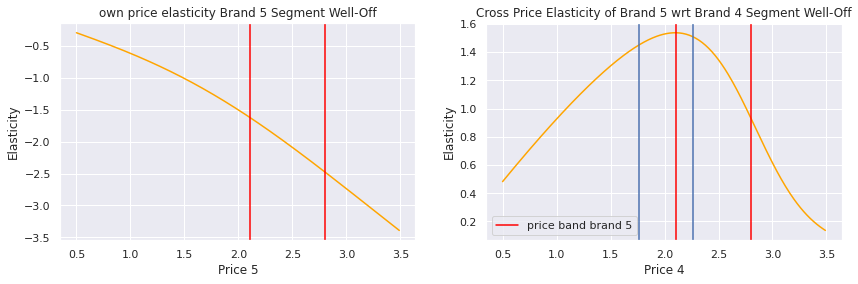

In [ ]:
# Plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s3, color = 'orange')
axs[0].set_title('own price elasticity Brand 5 Segment Well-Off')
axs[0].set_xlabel('Price 5')
axs[0].axvline(x = brand_choice_s3['Price_5'].min(), color = 'red')
axs[0].axvline(x = brand_choice_s3['Price_5'].max(), color = 'red')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Well-Off')
axs[1].set_xlabel('Price 4')
plt.axvline(x = brand_choice_s3['Price_4'].min())
plt.axvline(x = brand_choice_s3['Price_4'].max())
plt.axvline(x = brand_choice_s3['Price_5'].min(),color = 'red')
plt.axvline(x = brand_choice_s3['Price_5'].max(),color = 'red', label = 'price band brand 5')
plt.legend()

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')
plt.show()

### $\color{blue}{\text{Standard}}$

In [ ]:
# Here we are interesting in analysing the brand choice probability of the Standard segment.
# We filter our data, by selecting only purchases from segment 0.
brand_choice_s0 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s0 = brand_choice_s0[brand_choice_s0['Segment'] == 0]
brand_choice_s0.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
2398,200000024,44,1,2,2,0,0,1.35,1.58,1.97,2.09,2.67,1,1,1,0,0,1,1,32,1,88428,0,0,0,1,0,0,0
2403,200000024,98,1,2,2,0,0,1.47,1.90,1.95,2.12,2.67,0,0,0,0,0,1,1,32,1,88428,0,0,0,1,0,0,0
2408,200000024,143,1,2,3,0,0,1.21,1.35,1.99,2.16,2.67,1,1,0,0,0,1,1,32,1,88428,0,0,0,1,0,0,0
2410,200000024,162,1,2,5,0,0,1.39,1.90,1.94,2.16,2.49,1,0,0,0,0,1,1,32,1,88428,0,0,0,1,0,0,0
2417,200000024,217,1,5,1,0,0,1.34,1.89,1.99,2.13,2.67,0,0,0,0,0,1,1,32,1,88428,0,0,0,1,0,0,0


In [ ]:
# Brand Choice Model estimation.
Y = brand_choice_s0['Brand']
brand_choice_s0 = pd.get_dummies(brand_choice_s0, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s0[features]
model_brand_choice_s0 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 200)
model_brand_choice_s0.fit(X, Y)

# Coefficients table segment 0.
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s0.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{blue}{\text{Own-Brand Price Elasticity}}$

In [ ]:
# Calculating own-brand price elasticity for brand 5 and the Standard segment.
df_own_brand_5_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_own_brand_5_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_own_brand_5_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_own_brand_5_s0['Price_4'] = brand_choice_s0['Price_4'].mean()
df_own_brand_5_s0['Price_5'] = price_range

predict_own_brand_5_s0 = model_brand_choice_s0.predict_proba(df_own_brand_5_s0)
pr_own_brand_5_s0 = predict_own_brand_5_s0[: ][: , 4]

# Compute price elasticities and update master data frame.
# We'd like to include the elasticities for the segments in order from 0 to three, which is why we use insert() on position 10.
own_price_elasticity_brand_5_s0 =  beta5 * price_range * (1 - pr_own_brand_5_s0)
df_price_elasticities.insert(10, column = 'Brand 5 S0', value = own_price_elasticity_brand_5_s0)

### $\color{blue}{\text{Cross-Brand Price Elasticity}}$

In [ ]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Standard segment.
df_brand5_cross_brand4_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_brand5_cross_brand4_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_brand5_cross_brand4_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_brand5_cross_brand4_s0['Price_4'] = price_range
df_brand5_cross_brand4_s0['Price_5'] = brand_choice_s0['Price_5'].mean()

predict_brand5_cross_brand4_s0 = model_brand_choice_s0.predict_proba(df_brand5_cross_brand4_s0)
pr_cross_brand_5_s0 = predict_brand5_cross_brand4_s0[: ][: , 3]

# Compute price elasticities and update master data frame.
# We need to use insert() on position 11, to save the price elasticities in the correct order.
brand5_cross_brand4_price_elasticity_s0 = -beta5 * price_range * pr_cross_brand_5_s0
df_price_elasticities.insert(11, column = 'Brand_5_Cross_Brand_4_S0', value = brand5_cross_brand4_price_elasticity_s0)

### $\color{green}{\text{Career-Focused}}$

In [ ]:
# Filter data by the Career-focused segment, which is the first segment.
brand_choice_s1 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s1 = brand_choice_s1[brand_choice_s1['Segment'] == 1]

In [ ]:
# Brand Choice Model estimation.
Y = brand_choice_s1['Brand']
brand_choice_s1 = pd.get_dummies(brand_choice_s1, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s1[features]
model_brand_choice_s1 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s1.fit(X, Y)

# Coefficients table segment 1
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s1.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{green}{\text{Own-Brand Price Elasticity}}$

In [ ]:
# Calculating own-brand price elasticity for brand 5 and the Career-focused segment.
df_own_brand_5_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_own_brand_5_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_own_brand_5_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_own_brand_5_s1['Price_4'] = brand_choice_s1['Price_4'].mean()
df_own_brand_5_s1['Price_5'] = price_range

predict_own_brand_5_s1 = model_brand_choice_s1.predict_proba(df_own_brand_5_s1)
pr_own_brand_5_s1 = predict_own_brand_5_s1[: ][: , 4]

#compute price elasticities and update data frame
own_price_elasticity_brand_5_s1 =  beta5 * price_range * (1 - pr_own_brand_5_s1)
df_price_elasticities.insert(12, column = 'Brand 5 S1', value = own_price_elasticity_brand_5_s1)

### $\color{green}{\text{Cross-Brand Price Elasticity}}$

In [ ]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Career-focused segment.
df_brand5_cross_brand4_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_brand5_cross_brand4_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_brand5_cross_brand4_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_brand5_cross_brand4_s1['Price_4'] = price_range
df_brand5_cross_brand4_s1['Price_5'] = brand_choice_s1['Price_5'].mean()

predict_brand5_cross_brand4_s1 = model_brand_choice_s1.predict_proba(df_brand5_cross_brand4_s1)
pr_cross_brand_5_s1 = predict_brand5_cross_brand4_s1[: ][: , 3]

brand5_cross_brand4_price_elasticity_s1 = -beta5 * price_range * pr_cross_brand_5_s1
df_price_elasticities.insert(13, column = 'Brand_5_Cross_Brand_4_S1', value = brand5_cross_brand4_price_elasticity_s1)

### $\color{red}{\text{Fewer-Opportunities}}$

In [ ]:
# Filter data, select only purchases from segment 2, which is the Fewer-Opportunities segment.
brand_choice_s2 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s2 = brand_choice_s2[brand_choice_s2['Segment'] == 2]

In [ ]:
# Brand Choice Model estimation.
Y = brand_choice_s2['Brand']
brand_choice_s2 = pd.get_dummies(brand_choice_s2, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s2[features]
model_brand_choice_s2 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s2.fit(X, Y)

# Coefficients table segment 2
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s2.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{red}{\text{Own-Brand Price Elasticity}}$

In [ ]:
# Calculating own-brand price elasticity for brand 5 and the Fewer-opportunities segment.
df_own_brand_5_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_own_brand_5_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_own_brand_5_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_own_brand_5_s2['Price_4'] = brand_choice_s2['Price_4'].mean()
df_own_brand_5_s2['Price_5'] = price_range

predict_own_brand_5_s2 = model_brand_choice_s2.predict_proba(df_own_brand_5_s2)
pr_own_brand_5_s2 = predict_own_brand_5_s2[: ][: , 4]

#compute price elasticities and update data frame
own_price_elasticity_brand_5_s2 =  beta5 * price_range * (1 - pr_own_brand_5_s2)
df_price_elasticities.insert(14, column = 'Brand 5 S2', value = own_price_elasticity_brand_5_s2)

### $\color{red}{\text{Cross-Brand Price Elasticity}}$

In [ ]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Fewer-opportunities segment.
df_brand5_cross_brand4_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_brand5_cross_brand4_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_brand5_cross_brand4_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_brand5_cross_brand4_s2['Price_4'] = price_range
df_brand5_cross_brand4_s2['Price_5'] = brand_choice_s2['Price_5'].mean()

predict_brand5_cross_brand4_s2 = model_brand_choice_s2.predict_proba(df_brand5_cross_brand4_s2)
pr_cross_brand_5_s2 = predict_brand5_cross_brand4_s2[: ][: , 3]

brand5_cross_brand4_price_elasticity_s2 = -beta5 * price_range * pr_cross_brand_5_s2
df_price_elasticities.insert(15, column = 'Brand_5_Cross_Brand_4_S2', value = brand5_cross_brand4_price_elasticity_s2)
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096383,-0.211059,-0.118736,-0.030918,-0.168348,-0.125727,-0.195628,-0.049056,0.332012,-0.115835,0.174115,-0.043940,0.194772,-0.001036,0.181597,-0.297317,0.482421
1,0.51,-0.100450,-0.217626,-0.122906,-0.032684,-0.173284,-0.129842,-0.201748,-0.050617,0.337288,-0.118874,0.176171,-0.045027,0.197256,-0.001098,0.183894,-0.303363,0.491726
2,0.52,-0.104645,-0.224300,-0.127168,-0.034538,-0.178291,-0.134037,-0.207971,-0.052207,0.342507,-0.121948,0.178175,-0.046123,0.199689,-0.001163,0.186142,-0.309419,0.501015
3,0.53,-0.108969,-0.231082,-0.131524,-0.036482,-0.183370,-0.138312,-0.214298,-0.053827,0.347669,-0.125057,0.180129,-0.047228,0.202071,-0.001231,0.188341,-0.315486,0.510289
4,0.54,-0.113427,-0.237974,-0.135977,-0.038520,-0.188520,-0.142667,-0.220728,-0.055477,0.352774,-0.128202,0.182032,-0.048343,0.204403,-0.001303,0.190492,-0.321564,0.519548
5,0.55,-0.118021,-0.244976,-0.140527,-0.040658,-0.193742,-0.147105,-0.227264,-0.057159,0.357820,-0.131383,0.183886,-0.049468,0.206685,-0.001378,0.192595,-0.327654,0.528790
6,0.56,-0.122755,-0.252088,-0.145175,-0.042899,-0.199036,-0.151625,-0.233905,-0.058871,0.362810,-0.134601,0.185689,-0.050602,0.208918,-0.001458,0.194650,-0.333755,0.538016
7,0.57,-0.127632,-0.259312,-0.149924,-0.045248,-0.204404,-0.156229,-0.240652,-0.060615,0.367741,-0.137855,0.187444,-0.051745,0.211101,-0.001541,0.196657,-0.339869,0.547226
8,0.58,-0.132656,-0.266648,-0.154775,-0.047709,-0.209845,-0.160919,-0.247507,-0.062391,0.372615,-0.141147,0.189149,-0.052899,0.213235,-0.001629,0.198617,-0.345995,0.556420
9,0.59,-0.137830,-0.274097,-0.159729,-0.050288,-0.215360,-0.165694,-0.254470,-0.064200,0.377430,-0.144477,0.190806,-0.054062,0.215321,-0.001722,0.200530,-0.352134,0.565597


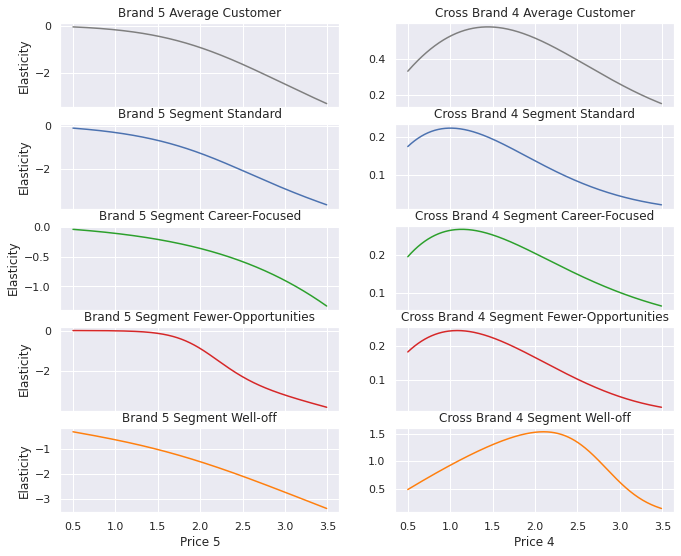

In [ ]:
# plot the own and cross brand price elasticities for the average customer and each of the four segments. 
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (11, 9), sharex = True)
ax1[0].plot(price_range, own_price_elasticity_brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity')
ax1[1].plot(price_range, brand5_cross_brand4_price_elasticity, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')


ax2[0].plot(price_range, own_price_elasticity_brand_5_s0)
ax2[0].set_title('Brand 5 Segment Standard')
ax2[0].set_ylabel('Elasticity')
ax2[1].plot(price_range, brand5_cross_brand4_price_elasticity_s0)
ax2[1].set_title('Cross Brand 4 Segment Standard')

ax3[0].plot(price_range, own_price_elasticity_brand_5_s1, 'tab:green')
ax3[0].set_title('Brand 5 Segment Career-Focused')
ax3[0].set_ylabel('Elasticity')
ax3[1].plot(price_range, brand5_cross_brand4_price_elasticity_s1, 'tab:green')
ax3[1].set_title('Cross Brand 4 Segment Career-Focused')

ax4[0].plot(price_range, own_price_elasticity_brand_5_s2, 'tab:red')
ax4[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax4[0].set_ylabel('Elasticity')
ax4[1].plot(price_range, brand5_cross_brand4_price_elasticity_s2, 'tab:red')
ax4[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')

ax5[0].plot(price_range, own_price_elasticity_brand_5_s3, 'tab:orange')
ax5[0].set_title('Brand 5 Segment Well-off')
ax5[0].set_xlabel('Price 5')
ax5[0].set_ylabel('Elasticity')
ax5[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, 'tab:orange')
ax5[1].set_title('Cross Brand 4 Segment Well-off')
ax5[1].set_xlabel('Price 4')
plt.show()


We can observe differences and similarities between the segments and examine their preference, when it comes to brand choice. The two segments, which seem to be of most interested for the marketing team of brand 5, seem to be the Career-focused and the Well-off. They are also the segments which purchase this brand most often. The Career-focused segment is the most inelastic and they are the most loyal segment. 
Based on our model, they do not seem to be that affected by price, therefore brand 5 could increase its price, without fear of significant loss of customers from this segment. The Well-off segment on the other hand, seems to be more elastic. They also purchase the competitor brand 4 most often. In order to target this segment, our analysis signals, that price needs to be decreased. However, keep in mind that other factors aside from price might be influencing the purchase behaivour of this segment.

## Price Elasticity of Purchase Quantity

We want to determine price elasticity of purchase quantity, also known as price elasticity of demand.
We are interested in purchase occasion, where the purchased quantity is different from 0.
Therefore, once again we filter our data to contain only shopping visits where the client has purchased at least one product.

As our data contains only price and promotion related data we will use these two features for modeling. else we can use place / placement as another factor for price elasticity of demand.

So we will create new features for `price incidence` and `promotion incidence` for category price elasticity of demand.

In [ ]:
# Filter the data for atleast 1 purchase
df_purchase_quantity = df_pa[df_pa['Incidence'] == 1]
df_purchase_quantity.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,2.09,2.67,0,0,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,2.12,2.62,1,0,0,0,1,0,0,47,1,110866,1,0,2,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,1.97,2.67,0,0,0,1,0,0,0,47,1,110866,1,0,2,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,2.16,2.68,1,1,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,1.89,2.37,1,0,0,1,1,0,0,47,1,110866,1,0,2,0,0,1,0


In [ ]:
# Create brand dummies, for each of the five brands.
df_purchase_quantity = pd.get_dummies(df_purchase_quantity, columns = ['Brand'], prefix = 'Brand', prefix_sep = '_')
df_purchase_quantity.describe()

,ID,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
count,1.463800e+04,14638.000000,14638.0,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000
mean,2.000003e+08,359.607597,1.0,2.774559,1.535251,0.406955,1.384559,1.764717,2.006694,2.159658,2.654296,0.372455,0.349638,0.043858,0.128091,0.045430,0.357289,0.385162,40.346905,1.151045,126706.452043,0.845471,0.797513,1.581910,0.175229,0.299290,0.293824,0.231657,0.092226,0.310288,0.057453,0.199959,0.340074
std,1.423786e+02,205.346253,0.0,1.796736,2.060858,0.491283,0.090944,0.181667,0.046200,0.093253,0.097724,0.483475,0.476872,0.204787,0.334203,0.208252,0.479217,0.486650,12.346284,0.634625,39935.109358,0.633840,0.810358,1.028171,0.380176,0.457962,0.455528,0.421906,0.289354,0.462627,0.232714,0.399983,0.473750
min,2.000000e+08,1.000000,1.0,1.000000,0.000000,0.000000,1.100000,1.260000,1.870000,1.760000,2.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,38247.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000001e+08,175.000000,1.0,2.000000,0.000000,0.000000,1.340000,1.570000,1.970000,2.120000,2.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,1.000000,102723.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000003e+08,355.000000,1.0,2.000000,0.000000,0.000000,1.390000,1.880000,2.010000,2.180000,2.670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,1.000000,122895.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000004e+08,532.000000,1.0,3.000000,4.000000,1.000000,1.470000,1.890000,2.060000,2.240000,2.700000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,49.000000,2.000000,147967.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2.000005e+08,727.000000,1.0,15.000000,5.000000,1.000000,1.590000,1.900000,2.140000,2.260000,2.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,75.000000,3.000000,309364.000000,2.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The descriptive analysis of the purchase quantitiy data frame, shows that quantity ranges from 1 to 15 and has an average value of 2.8, which means that more often than not our customers buy more than 1 chocolate candy bar.


In [ ]:
# Here we make a decission on which features to include in our model. We decide to include a Price and a Promotion feature.
# df_purchase_quantity.columns.values

In [ ]:
#Find the price of the brand / product / SKU that is chosen at this incidence
df_purchase_quantity['Price_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Price_1'] +
                                           df_purchase_quantity['Brand_2'] * df_purchase_quantity['Price_2'] +
                                           df_purchase_quantity['Brand_3'] * df_purchase_quantity['Price_3'] +
                                           df_purchase_quantity['Brand_4'] * df_purchase_quantity['Price_4'] +
                                           df_purchase_quantity['Brand_5'] * df_purchase_quantity['Price_5'] )

In [ ]:
# Find the price of the brand / product / SKU that is chosen at this incidence
df_purchase_quantity['Promotion_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Promotion_1'] +
                                               df_purchase_quantity['Brand_2'] * df_purchase_quantity['Promotion_2'] +
                                               df_purchase_quantity['Brand_3'] * df_purchase_quantity['Promotion_3'] +
                                               df_purchase_quantity['Brand_4'] * df_purchase_quantity['Promotion_4'] +
                                               df_purchase_quantity['Brand_5'] * df_purchase_quantity['Promotion_5'] )

## Model Estimation. Linear Regression

In [ ]:
X = df_purchase_quantity[['Price_Incidence', 'Promotion_Incidence']]
pd.options.display.max_rows = 100
X

,Price_Incidence,Promotion_Incidence
6,1.90,0
11,2.62,1
19,1.47,0
24,2.16,0
29,1.88,0
...,...,...
58621,1.89,0
58648,1.35,1
58674,1.85,1
58687,1.51,0


In [ ]:
Y = df_purchase_quantity['Quantity']
Y.head()

6     2
11    1
19    2
24    1
29    3
Name: Quantity, dtype: int64

In [ ]:
# Linear Regression Model
model_quantity = LinearRegression()
model_quantity.fit(X, Y)

LinearRegression()

In [ ]:
# model coefficients
model_quantity.coef_

array([-0.8173651 , -0.10504673])

Linear Regression Model. The coefficients for price and promotion are both negative.  It appears that promotion reflects negatively on the purchase quantity of the average client, which is unexpected.

## Price Elasticity with Promotion

In [ ]:
# We examine the price elasticity of purchase quantity with active promotional activities for each price point.
df_price_elasticity_quantity = pd.DataFrame(index = np.arange(price_range.size))
df_price_elasticity_quantity['Price_Incidence'] = price_range
df_price_elasticity_quantity['Promotion_Incidence'] = 1

In [ ]:
#Take the coefficient for price.
beta_quantity = model_quantity.coef_[0]
beta_quantity

-0.8173651016684991

In [ ]:
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

In [ ]:
# We calculate the price elasticity with a new formula. 
# It is the beta coefficient for price multiplied by price and divided by the purchase quantity.
price_elasticity_quantity_promotion_yes = beta_quantity * price_range / predict_quantity

In [ ]:
# add it to the master data frame
df_price_elasticities['PE_Quantity_Promotion_1'] = price_elasticity_quantity_promotion_yes
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3,PE_Quantity_Promotion_1
0,0.50,-0.096383,-0.211059,-0.118736,-0.030918,-0.168348,-0.125727,-0.195628,-0.049056,0.332012,-0.115835,0.174115,-0.043940,0.194772,-0.001036,0.181597,-0.297317,0.482421,-0.102157
1,0.51,-0.100450,-0.217626,-0.122906,-0.032684,-0.173284,-0.129842,-0.201748,-0.050617,0.337288,-0.118874,0.176171,-0.045027,0.197256,-0.001098,0.183894,-0.303363,0.491726,-0.104413
2,0.52,-0.104645,-0.224300,-0.127168,-0.034538,-0.178291,-0.134037,-0.207971,-0.052207,0.342507,-0.121948,0.178175,-0.046123,0.199689,-0.001163,0.186142,-0.309419,0.501015,-0.106679
3,0.53,-0.108969,-0.231082,-0.131524,-0.036482,-0.183370,-0.138312,-0.214298,-0.053827,0.347669,-0.125057,0.180129,-0.047228,0.202071,-0.001231,0.188341,-0.315486,0.510289,-0.108954
4,0.54,-0.113427,-0.237974,-0.135977,-0.038520,-0.188520,-0.142667,-0.220728,-0.055477,0.352774,-0.128202,0.182032,-0.048343,0.204403,-0.001303,0.190492,-0.321564,0.519548,-0.111238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.012279,-5.050246,-5.672867,-12.537309,-4.031233,-4.861106,-4.982738,-3.231574,0.162233,-3.592453,0.024055,-1.287424,0.068592,-3.746081,0.023405,-3.337317,0.157480,-1.774292
296,3.46,-8.037527,-5.067100,-5.693019,-12.574215,-4.046119,-4.879307,-4.999644,-3.247767,0.160333,-3.606358,0.023698,-1.297233,0.067969,-3.757523,0.022946,-3.350647,0.152058,-1.788634
297,3.47,-8.062742,-5.083935,-5.713134,-12.611103,-4.060989,-4.897478,-5.016529,-3.263929,0.158447,-3.620218,0.023347,-1.307098,0.067351,-3.768945,0.022493,-3.363974,0.146802,-1.803124
298,3.48,-8.087922,-5.100751,-5.733213,-12.647976,-4.075843,-4.915618,-5.033394,-3.280059,0.156576,-3.634034,0.022999,-1.317017,0.066737,-3.780347,0.022047,-3.377298,0.141707,-1.817766


Text(0.5, 1.0, 'Price Elasticity of Purchase Quantity with Promotion')

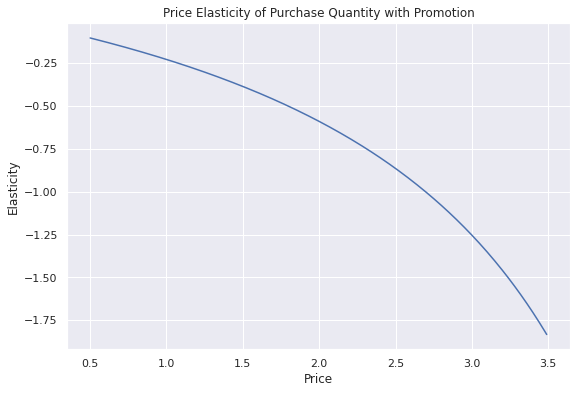

In [ ]:
# plot the price elasticity of purchase quantity with promotion
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Quantity with Promotion')

## Price Elasticity without Promotion

In [ ]:
# Overwrite promotion incidence in order to use the same df. 
# Here we assume there are no promotinal activities active for the entire price range.
df_price_elasticity_quantity['Promotion_Incidence'] = 0
# Find the new predicted quantities.
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)
# Calculate the new price elasticities.
price_elasticity_quantity_promotion_no = beta_quantity * price_range / predict_quantity
# Add the results to the master data frame.
df_price_elasticities['PE_Quantity_Promotion_0'] = price_elasticity_quantity_promotion_no
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3,PE_Quantity_Promotion_1,PE_Quantity_Promotion_0
0,0.50,-0.096383,-0.211059,-0.118736,-0.030918,-0.168348,-0.125727,-0.195628,-0.049056,0.332012,-0.115835,0.174115,-0.043940,0.194772,-0.001036,0.181597,-0.297317,0.482421,-0.102157,-0.099543
1,0.51,-0.100450,-0.217626,-0.122906,-0.032684,-0.173284,-0.129842,-0.201748,-0.050617,0.337288,-0.118874,0.176171,-0.045027,0.197256,-0.001098,0.183894,-0.303363,0.491726,-0.104413,-0.101736
2,0.52,-0.104645,-0.224300,-0.127168,-0.034538,-0.178291,-0.134037,-0.207971,-0.052207,0.342507,-0.121948,0.178175,-0.046123,0.199689,-0.001163,0.186142,-0.309419,0.501015,-0.106679,-0.103939
3,0.53,-0.108969,-0.231082,-0.131524,-0.036482,-0.183370,-0.138312,-0.214298,-0.053827,0.347669,-0.125057,0.180129,-0.047228,0.202071,-0.001231,0.188341,-0.315486,0.510289,-0.108954,-0.106150
4,0.54,-0.113427,-0.237974,-0.135977,-0.038520,-0.188520,-0.142667,-0.220728,-0.055477,0.352774,-0.128202,0.182032,-0.048343,0.204403,-0.001303,0.190492,-0.321564,0.519548,-0.111238,-0.108369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.012279,-5.050246,-5.672867,-12.537309,-4.031233,-4.861106,-4.982738,-3.231574,0.162233,-3.592453,0.024055,-1.287424,0.068592,-3.746081,0.023405,-3.337317,0.157480,-1.774292,-1.664290
296,3.46,-8.037527,-5.067100,-5.693019,-12.574215,-4.046119,-4.879307,-4.999644,-3.247767,0.160333,-3.606358,0.023698,-1.297233,0.067969,-3.757523,0.022946,-3.350647,0.152058,-1.788634,-1.677205
297,3.47,-8.062742,-5.083935,-5.713134,-12.611103,-4.060989,-4.897478,-5.016529,-3.263929,0.158447,-3.620218,0.023347,-1.307098,0.067351,-3.768945,0.022493,-3.363974,0.146802,-1.803124,-1.690246
298,3.48,-8.087922,-5.100751,-5.733213,-12.647976,-4.075843,-4.915618,-5.033394,-3.280059,0.156576,-3.634034,0.022999,-1.317017,0.066737,-3.780347,0.022047,-3.377298,0.141707,-1.817766,-1.703414


Text(0.5, 1.0, 'Price Elasticity of Purchase Quantity with Promotion')

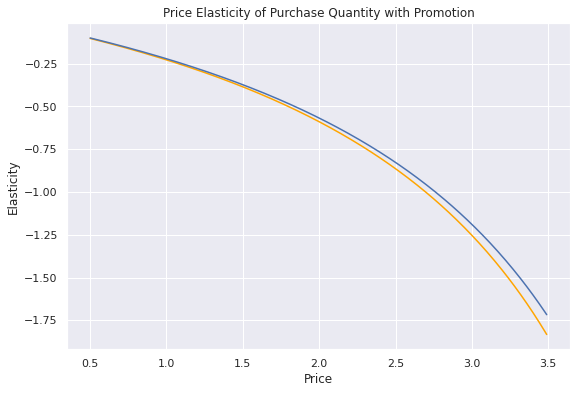

In [ ]:
# Plot the two elasticities side by side. 
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes, color = 'orange')
plt.plot(price_range, price_elasticity_quantity_promotion_no)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Quantity with Promotion')

**We observe that the two elasticities are very close together for almost the entire price range.
It appears that promotion does not appear to be a significant factor in the customers' decission what quantity of chocolate candy bars to purchase.**